## Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Get the data - features and **target**

The dataset is loaded from the repository. The "food" column is dropped,as the names are not necessary for numerical analysis.

In [4]:
import os
from pathlib import Path

# Load data
path = Path(os.getcwd() + "/..").resolve()
dataset_path = path/'Datasets/Tabular/FOOD-DATA-GROUP.csv'
df = pd.read_csv(dataset_path)

df = df.drop("food", axis=1)
features = df.drop("Caloric Value", axis=1).columns.tolist()
target = "Caloric Value"

> As observed by the histograms in data analysis, the data is skewed. Transformation is needed to get a more normally distributed data.



## Data Transformation and Normalization
### Yeo-Johnson transformation
The Yeo-Johnson transformation is used to stabilize variance and make data more normally distributed. This transformation is an extension of the Box-Cox transformation to deal with data that includes both positive and negative values.

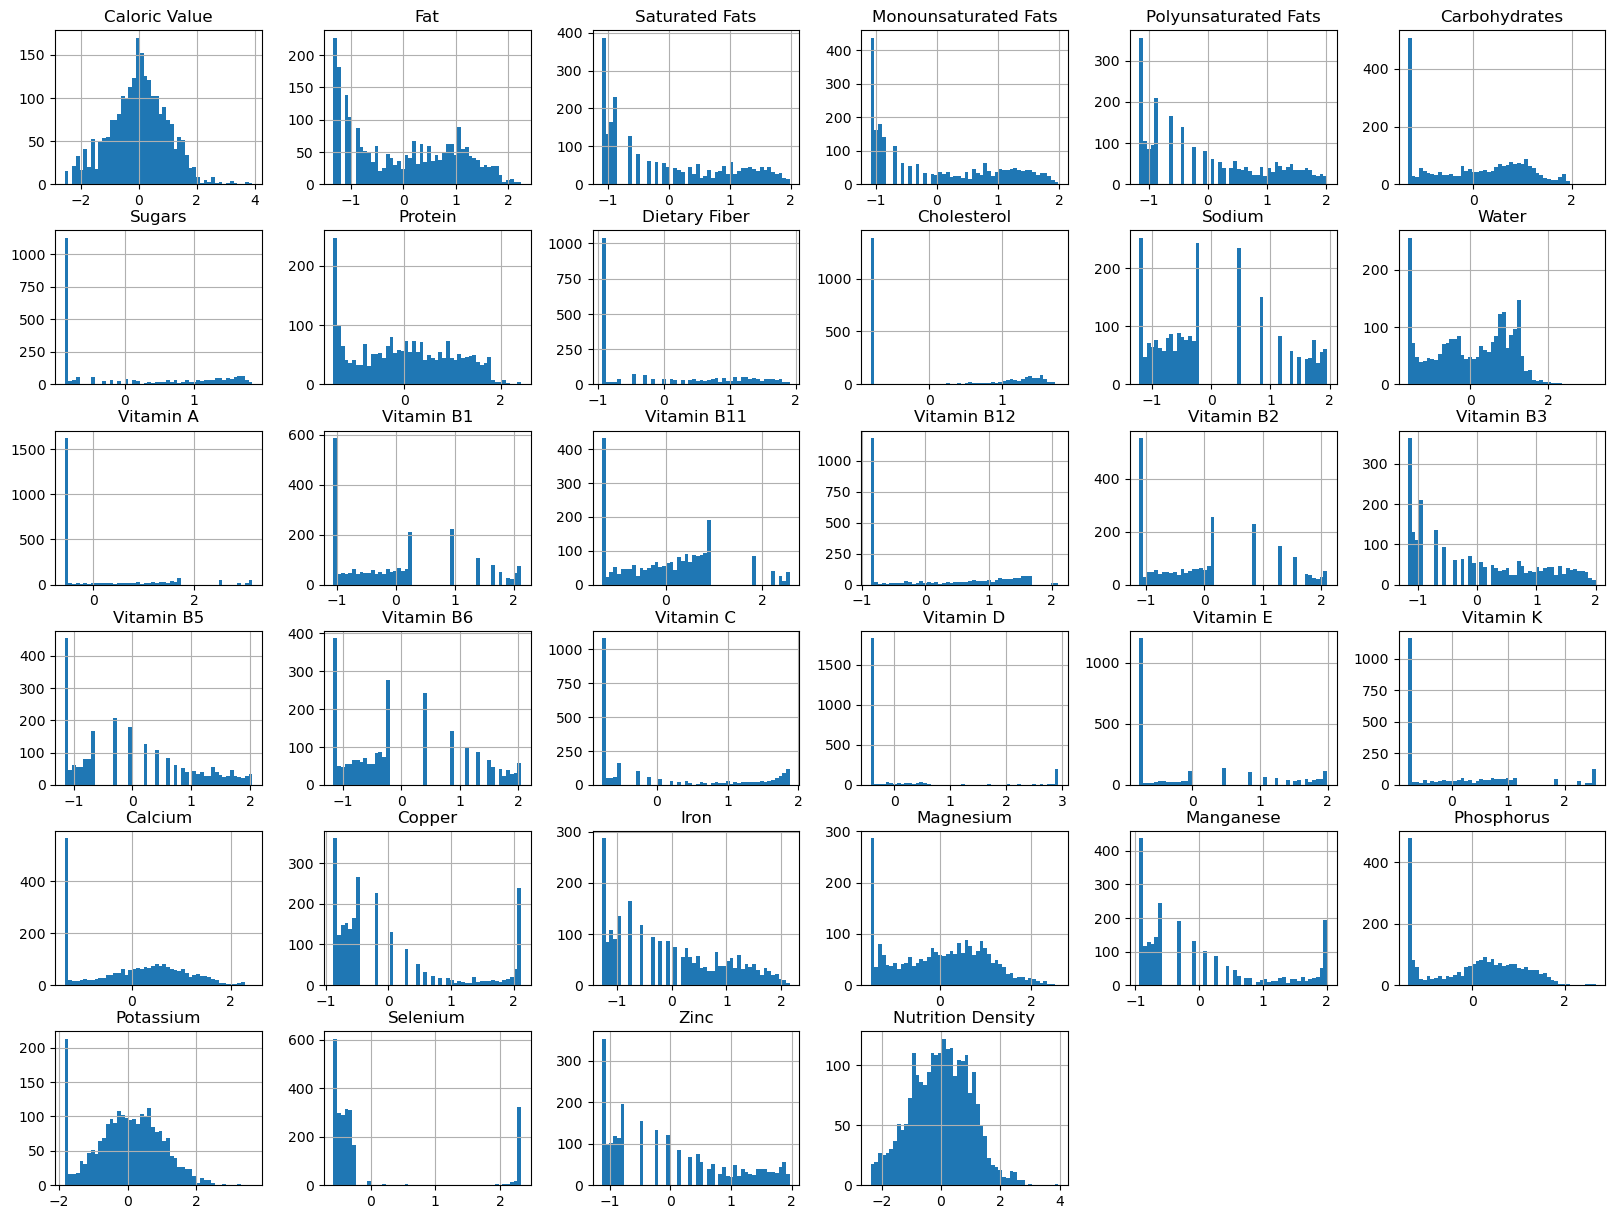

In [7]:
from sklearn.preprocessing import PowerTransformer

# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Transform the data
df_transformed = pt.fit_transform(df)

# Convert back to DataFrame
df = pd.DataFrame(df_transformed, columns=df.columns)

# Visualizing the transformed data
df.hist(bins=50, figsize=(20,15))
plt.show()

It can be observed from the histograms that the application of the Yeo-Johnson transformation successfully normalized the distribution of the dataset.

## Outlier Detection

### z-score
Z-scores are the number of standard deviations above and below the mean for each value. A Z-score above 3 or below -3 is often considered an outlier.

A threshold value is a predetermined limit or cutoff point that helps determine what is considered an anomaly or outlier within a dataset.

In [11]:
from scipy.stats import zscore
import numpy as np

X = df[features]

# Calculate Z-scores for the features
z_scores = np.abs(zscore(X))

# Define a threshold for Z-scores
threshold = 3

# Find rows where all features have Z-scores greater than the threshold
outliers = (z_scores > threshold).any(axis=1)
print(f"Outliers found: {outliers.sum()}")

Outliers found: 67


### Remove the found outliers
The outliers variable holds a boolean array indicating whether each row contains an outlier based on this threshold.

In [13]:
# Remove rows where any feature's Z-score exceeds the threshold
X_clean_zscore = X[~outliers]

# Get the indices of the rows that are not outliers
valid_indices = X[~outliers].index

df = df.loc[valid_indices]

## Pearson's correlation coefficient
Pearson's correlation is a statistical method used to measure the linear correlation between two variables. The correlation coefficients are in the range –1 to 1. Two features have a perfect positive correlation if r = 1 , no correlation if r = 0, and a perfect negative correlation if r = –1.

In [15]:
# Get the correlation of features with the target
corr = df.corr()[target].sort_values(ascending=False)[1:]

# Absolute for positive values
abs_corr = abs(corr)

# Consider all features with more than 0.1 correlation with the target
relevant_features = abs_corr[abs_corr>0.1]
new_df = df[relevant_features.index]
features = new_df.columns.tolist()

print(f"Features with correlativity greater than 0.1 or less than -0.1: {features}")

Features with correlativity greater than 0.1 or less than -0.1: ['Nutrition Density', 'Fat', 'Protein', 'Polyunsaturated Fats', 'Saturated Fats', 'Monounsaturated Fats', 'Zinc', 'Iron', 'Vitamin B3', 'Phosphorus', 'Potassium', 'Magnesium', 'Vitamin B1', 'Vitamin B2', 'Vitamin B5', 'Vitamin B6', 'Calcium', 'Cholesterol', 'Carbohydrates', 'Sodium', 'Water', 'Vitamin E', 'Dietary Fiber', 'Vitamin A', 'Vitamin B11', 'Manganese', 'Copper', 'Vitamin D', 'Selenium']



## Feature Extraction


### Create features manually

In [18]:
df['Protein+Carbohydrates+Fat'] = df['Protein']+df['Carbohydrates']+df['Fat']
df['Total Fats'] = df['Polyunsaturated Fats'] + df['Saturated Fats'] + df['Monounsaturated Fats']

new_features = ['Protein+Carbohydrates+Fat', 'Total Fats']

### Correlation matrix
The correlation matrix is a square matrix that contains the Pearson correlation coefficient, which measures the linear dependence between pairs of features.

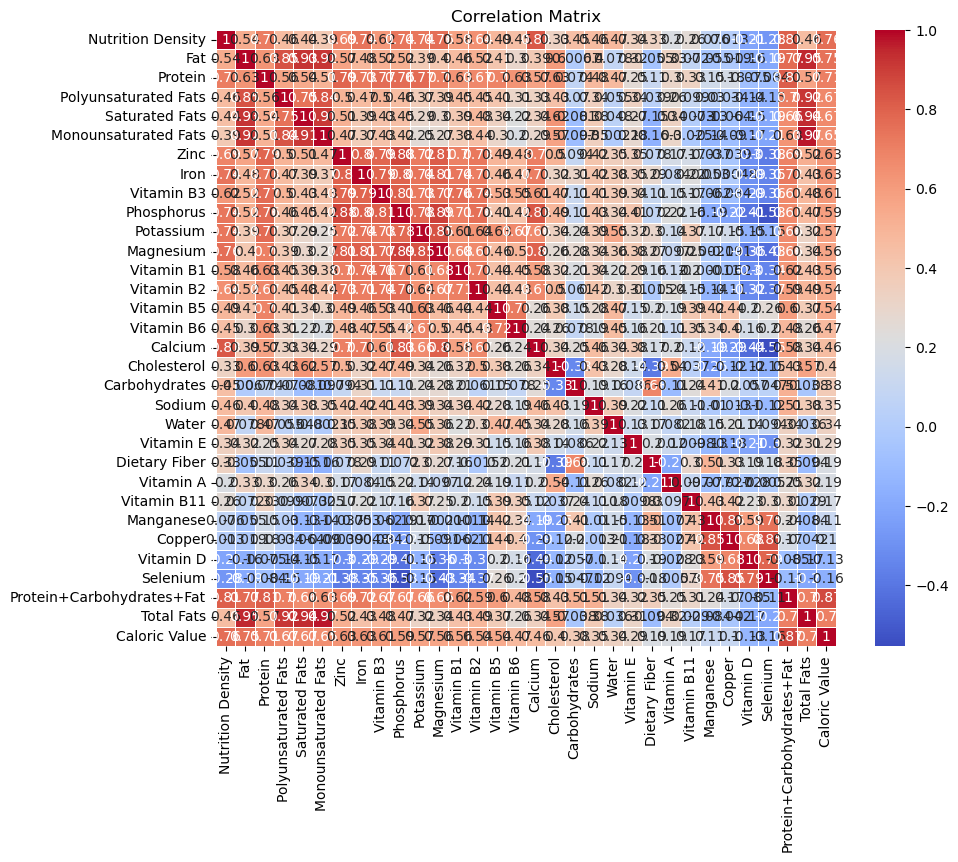

In [20]:
import numpy as np
X = df[features + new_features]
feature_names = np.array(X.columns)
corr = df[np.concatenate((feature_names, [target]))].corr()

import matplotlib.pyplot as plt
import seaborn as sns

### Heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Remove features related with other features

The correlation matrix reveals multicollinearity among certain features. By removing these correlated features, we reduced redundancy in the dataset.

* Polyunsaturated Fats, Saturated Fats, Monounsaturated Fats are related to Total Fats
* Vitamin A is related to Water
* Magnesium, Vitamin B2, Calcium are related to Phosphorus
* Phosphorus, Iron is related to Zinc
* Vitamin B5, Potassium is related to Protein
* Fat is related to Total Fats
* Vitamin B11, Protein is related to Protein+Carbohydrates+Fat

In [22]:
features = ['Nutrition Density', 'Zinc', 'Vitamin B3', 'Vitamin B1', 'Vitamin B6', 'Calcium', 'Cholesterol', 'Sodium', 'Water', 'Dietary Fiber', 'Sugars', 'Vitamin C', 'Selenium' ]
X = df[features + new_features]
y = df[target]
feature_names = np.array(X.columns)

### Extract top features

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the loss between the observed targets in the dataset, and the targets predicted by the linear approximation.

The Sequential Feature Selector here starts with all the features and removes features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import root_mean_squared_error, r2_score

lin_reg_results = []

for n in range(7, 11):
  feature_selector = SequentialFeatureSelector(
        LinearRegression(),
        n_features_to_select=n,
        direction="backward",
        scoring="r2",
        tol=-1e-4,
        n_jobs=-1,
  )
  model = make_pipeline(feature_selector, LinearRegression())
  model.fit(X, y)
  selected_features = feature_selector.get_support()
  print(f"Features selected: {feature_names[selected_features]}")

  predictions = model.predict(X)
  rmse = root_mean_squared_error(y, predictions)
  r2 = r2_score(y, predictions)

  print(f"Root Mean Squared Error: {rmse:.3f}")
  print(f"R² Score: {r2:.3f}")

Features selected: ['Nutrition Density' 'Calcium' 'Sodium' 'Dietary Fiber' 'Vitamin C'
 'Selenium' 'Protein+Carbohydrates+Fat']
Root Mean Squared Error: 0.354
R² Score: 0.869
Features selected: ['Nutrition Density' 'Zinc' 'Calcium' 'Sodium' 'Dietary Fiber' 'Vitamin C'
 'Selenium' 'Protein+Carbohydrates+Fat']
Root Mean Squared Error: 0.350
R² Score: 0.872
Features selected: ['Nutrition Density' 'Zinc' 'Calcium' 'Sodium' 'Dietary Fiber' 'Vitamin C'
 'Selenium' 'Protein+Carbohydrates+Fat' 'Total Fats']
Root Mean Squared Error: 0.338
R² Score: 0.880
Features selected: ['Nutrition Density' 'Zinc' 'Vitamin B3' 'Calcium' 'Sodium'
 'Dietary Fiber' 'Vitamin C' 'Selenium' 'Protein+Carbohydrates+Fat'
 'Total Fats']
Root Mean Squared Error: 0.335
R² Score: 0.882


The feature set with minimum RMSE and maximum R² score which includes 10 features.
Selected features = ['Nutrition Density' 'Zinc' 'Vitamin B3' 'Calcium' 'Sodium' 'Dietary Fiber' 'Vitamin C' 'Selenium' 'Protein+Carbohydrates+Fat' 'Total Fats']